# Variational Quantum Classifier (VQC) Splitting

This notebook will explore the Qiskit implementation of a VQC, and initial attempts to split the VQC into parts to explain.

In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [ ]:
# imports
from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import clear_output

import os
import time

# import data class
from utilities.dataset_utils import DiabetesData

# import metrics for evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# qiskit imports
# circuit transpiler
from qiskit import transpile

# algorithm
from qiskit_machine_learning.algorithms.classifiers import VQC

# feature map
from qiskit.circuit.library import ZZFeatureMap

# ansatz
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit.library import EfficientSU2

# optimizer
from qiskit_machine_learning.optimizers import COBYLA

# simulator
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler

### VQC Overview
A Variational Quantum Classifier is a hybrid quantum-classical machine learning algorithm used for classification. It encodes the classical data using a feature map, which maps the data onto qubits to take advantage of quantum phenomena. The encoded data is processed through a variational quantum circuit (consists of parameterized gates). These parameters are iteratively optimised using classical algorithms to minimise a cost function (difference between predicted and true labels). After processing, quantum circuit is measured, and results are post processed to produce predictions. 
This hybrid approach allows the VQC allows the combination of the power of quantum mechanics with classical optimisation techniques, offering advantages for complex classification problems that would be challenging for a purely classical approach

In [14]:
# path to diabetes.csv
path = os.path.join(os.getcwd(), '..', '..', 'utilities', 'diabetes.csv')
# load dataset class
dataset = DiabetesData(path)

In [ ]:
# setup backend simulator
backend = AerSimulator(method='statevector')

In [16]:
# feature map
feature_map = ZZFeatureMap(feature_dimension=dataset.get_num_features(), reps=1, entanglement='circular')
feature_map = transpile(feature_map, backend=backend) # transpile to backend

In [17]:
# ansatz
ansatz = EfficientSU2(num_qubits=dataset.get_num_features(), reps=3, entanglement='circular')
ansatz = transpile(ansatz, backend=backend) # transpile to backend

In [18]:
# callback graph
# init list to store objective function values
objective_func_vals = []

# larger size for graph
plt.rcParams["figure.figsize"] = (12, 6)

# callback function to plot objective function value (updates after each iteration)
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective Function Value")
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.plot(objective_func_vals)
    plt.show()

In [19]:
# optimizer
optimizer = COBYLA(maxiter=500)

In [20]:
# sampler
sampler = Sampler.from_backend(backend)

In [21]:
# create the VQC instance
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


### Model Fit on Simulator

In [22]:
# get training and testing data
X_train, X_test, y_train, y_test = dataset.preprocess_data()

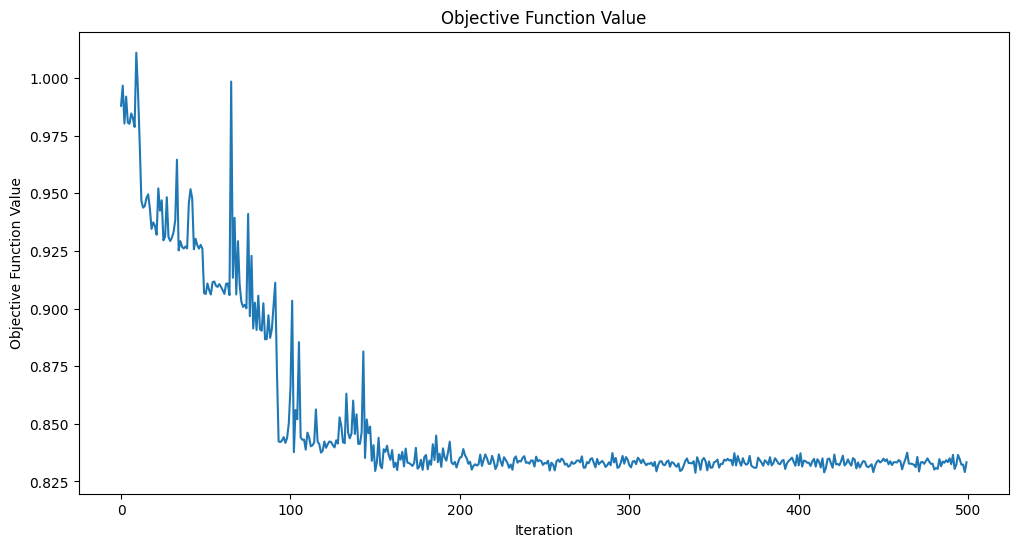

Training Time: 2154 secs
[0.9879272133748301, 0.9966689250621429, 0.9802371682333041, 0.9919210432801151, 0.9806806294727907, 0.9801195241045872, 0.9846270287146903, 0.9825348557395124, 0.9787541097482088, 1.0109554192211823, 0.9943050461991616, 0.9719395855248535, 0.9467619795133715, 0.943761328999497, 0.9444233765650304, 0.947928085830897, 0.9495300100412586, 0.9434920889592704, 0.9345543878932232, 0.9373695551876234, 0.9358553345965369, 0.9319983564008198, 0.9521205552154889, 0.942425173177645, 0.9469373037393758, 0.9295731414322986, 0.9311333077580931, 0.9482936402453755, 0.9310039468240273, 0.9293146280557926, 0.930648991955045, 0.933170201017059, 0.9383488792996759, 0.9645361685462337, 0.9252004330688484, 0.9292276142803633, 0.9267673084754159, 0.926023548074037, 0.9269129774195605, 0.9260765514466209, 0.9455564094589693, 0.9517538037533461, 0.9477624289451727, 0.9257071631228796, 0.9302554496376028, 0.9274406129511681, 0.925976491532047, 0.9276159824943107, 0.9259563945396453, 0

In [23]:
# time how long it takes to train
start = time.time()

# fit the model
vqc = vqc.fit(X_train, y_train)

end = time.time()
elapsed = end - start

# print training time
print(f"Training Time: {round(elapsed)} secs")

# print objective func val at each iteration
print(objective_func_vals)

### VQC Evaluation

In [24]:
# reset rcParams to default
plt.rcParams["figure.figsize"] = (6,4)

In [25]:
train_score = vqc.score(X_train, y_train)
test_score = vqc.score(X_test, y_test)
train_score, test_score

(0.6840390879478827, 0.6558441558441559)

In [26]:
# predict
y_pred = vqc.predict(X_test)

In [27]:
# confusion matrix
def conf_matrix(y_test, y_pred):
    plt.figure()
    cm = confusion_matrix(y_test, y_pred)
    heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title('Confusion Matrix: VQC')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [28]:
# accuracy score
accuracy = accuracy_score(y_test, y_pred)

In [29]:
# classification report
report = classification_report(y_test, y_pred, zero_division=0, output_dict=False)

Accuracy: 0.6623376623376623
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.79      0.75       100
           1       0.52      0.43      0.47        54

    accuracy                           0.66       154
   macro avg       0.62      0.61      0.61       154
weighted avg       0.65      0.66      0.65       154



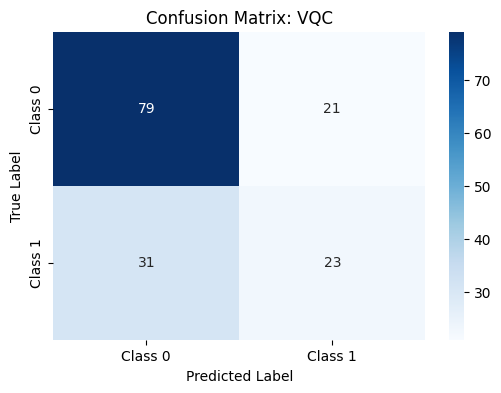

In [30]:
# print metrics
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')
conf_matrix(y_test, y_pred)

### Applying Explainability Techniques
##### **Pre-Prediciton**
1) **Feature Map**
    - Perturbation Analysis
    - Leave-One-Out (LOO) Analysis
    - Permutation Importance
    - SHAP (Feature Encoding)

    
##### **Post-Prediction**
1) **Ansatz (Variational Circuit)**
    - Parameter Sensitivity Analysis
    - Quantum Fisher Information (QFI)
    - Gradient-Based Analysis
    - Circuit Visualisation
    - SHAP (Parameters)
      - Applying importance scores to asses contribution to 
2) **Measurement + Post Processing**
    - SHAP (Predicitons)
    - ALE
    - Probability Attribution Analysis
3) **Cost**
    - Loss Contribution Analysis
    - Perturbation Sensitivity on Loss
    - Quantum-Classical Hybrid Loop Analysis